# Business Analytics - Assignment 4
#### **Student Name:** Koorosh Shakoori

## Loading and processing the dataset
considering the fact that two features, namely Type and sex, are of object type, we need to encode them into numerical format.

Both features have only 2 unique values. Hence, after getting their encoded versions, we will remove one of each feature columns to prevent feeding redundant data into our model. This will lead into features described as below:
- sex_M:
    - 1 if male
    - 0 if female
    
- Type_Surgical:
    - 1 if Surgical patient
    - 0 if Medical patient
    

In [1]:
import pandas as pd
data = pd.read_csv('MiniExam4Dataset.csv')
data = pd.get_dummies(data, columns=['sex', 'Type'], prefix=['sex', 'Type'])
X = data.drop(['death', 'sex_F', 'Type_Medical'], axis=1)
y = data.death 

## (a)
The data is split between train and test datasets. the test ratio is set to 20% as requested in the problem.

A random_state value has been assigned for consistency.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## (b)
Considering we are using cross validation approaches, the standardization is not performed separately at the beginning due to data leakage. Instead, this step is performed via pipelines in each experiment individually.

For each experiment, a set of c(in case of regularized logistic regression) and k(in case of KNN) values has been defined. a loop iterates through said lists of parameters and using a 10-fold cross validation method, the models are evaluated by the resulting accuracy scores.


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

In [4]:
C_params = [0.001,0.01,0.1,1,10,100,1000,10000]
scores = []
for c in C_params:
    model = LogisticRegression(C=c,penalty='l1', max_iter=1000, solver='liblinear')
    pipe = make_pipeline(preprocessing.StandardScaler(), model)
    score = cross_val_score(pipe, X_train, y_train, cv=10, scoring='accuracy').mean()
    scores.append([score, c])

scores_df = pd.DataFrame(scores, columns=['Validation Accuracy', 'C'])

l1_C = scores_df.loc[scores_df["Validation Accuracy"].idxmax(), 'C']
l1_score = scores_df["Validation Accuracy"].max()
print('the results for l1 regularized logistic regression are:')
print(f'best C value: {l1_C}')
print(f'best score: {l1_score}')
print(scores_df)

the results for l1 regularized logistic regression are:
best C value: 0.1
best score: 0.9025000000000001
   Validation Accuracy          C
0               0.8075      0.001
1               0.8075      0.010
2               0.9025      0.100
3               0.9000      1.000
4               0.9000     10.000
5               0.9025    100.000
6               0.9025   1000.000
7               0.9025  10000.000


In [5]:
C_params = [0.001,0.01,0.1,1,10,100,1000,10000]
scores = []
for c in C_params:
    model = LogisticRegression(C=c,penalty='l2',max_iter=1000)
    pipe = make_pipeline(preprocessing.StandardScaler(), model)
    score = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=10).mean()
    scores.append([score, c])

scores_df = pd.DataFrame(scores, columns=['Validation Accuracy', 'C'])

l2_C = scores_df.loc[scores_df["Validation Accuracy"].idxmax(), 'C']
l2_score = scores_df["Validation Accuracy"].max()
print('the results for l2 regularized logistic regression are:')
print(f'best C value: {l2_C}')
print(f'best score: {l2_score}')
print(scores_df)

the results for l2 regularized logistic regression are:
best C value: 10.0
best score: 0.9025000000000001
   Validation Accuracy          C
0               0.8075      0.001
1               0.8800      0.010
2               0.8950      0.100
3               0.9000      1.000
4               0.9025     10.000
5               0.9025    100.000
6               0.9025   1000.000
7               0.9025  10000.000


While regularization in the methods above was implemented to emulate a feature selection process, the KNN method lacks such sophistication.

To address the redundency of data, and select a suitable subset of features that works best with this algorithm, the Sequential Feature Selection is used.

This method is examined both in forward and backward manner. The steps to this approach is:
- 1: Select a K value
- 2: Run the SFS algorithm on the standardized training dataset and choose the best performing subset according to cross validation score
- 3: After iterating through all K values, the best performing one and its respective feature subset is selected as the best KNN model

For comparison purposes, first a set of normal KNN models are trained and evaluated with cross validation.


In [6]:
from sklearn.neighbors import KNeighborsClassifier
K_params = list(range(3, 26))
scores = []
for k in K_params:
    model = KNeighborsClassifier(n_neighbors=k)
    pipe = make_pipeline(preprocessing.StandardScaler(), model)
    score = cross_val_score(pipe, X_train, y_train, cv=10, scoring='accuracy').mean()
    scores.append([score, k])

scores_df = pd.DataFrame(scores, columns=['Validation Accuracy', 'K'])

best_k = scores_df.loc[scores_df["Validation Accuracy"].idxmax(), 'K']
best_k_score = scores_df["Validation Accuracy"].max()
print('the results for normal KNN are:')
print(f'best K value: {best_k}')
print(f'best score: {best_k_score}')
print(scores_df)

the results for normal KNN are:
best K value: 9
best score: 0.905
    Validation Accuracy   K
0                0.8900   3
1                0.8775   4
2                0.8850   5
3                0.8850   6
4                0.8925   7
5                0.8950   8
6                0.9050   9
7                0.8975  10
8                0.8975  11
9                0.8925  12
10               0.9050  13
11               0.8925  14
12               0.8975  15
13               0.8875  16
14               0.8925  17
15               0.8950  18
16               0.9000  19
17               0.8950  20
18               0.8950  21
19               0.8925  22
20               0.8950  23
21               0.8925  24
22               0.8900  25


In [7]:
#This block executes the Forward Feature Selection approach combined with KNN
#Note that we use the same pipeline practice to prevent data leakage
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

K_params = list(range(3, 26))
scores = []
for k in K_params:
    model = KNeighborsClassifier(n_neighbors=k)
    pipe = make_pipeline(preprocessing.StandardScaler(), model)
    sfs = SFS(model, 
           k_features=14, 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=10)
    sfs = sfs.fit(X_train, y_train)
    sfs.k_feature_names_ = X_train.columns
    score = sorted(sfs.get_metric_dict().values(), key=lambda x: x['avg_score'], reverse=True)[0]['avg_score']
    subset = sorted(sfs.get_metric_dict().values(), key=lambda x: x['avg_score'], reverse=True)[0]['feature_names']
    scores.append([score, subset, k])

scores_df = pd.DataFrame(scores, columns=['Validation Accuracy', 'Selected Features', 'K'])
best_forward_k = scores_df.loc[scores_df['Validation Accuracy'].idxmax(), 'K']
best_forward_score = scores_df['Validation Accuracy'].max()
best_forward_feature_subset = list(scores_df.loc[scores_df['Validation Accuracy'].idxmax(), 'Selected Features'])
print('the results for KNN in FFS are:')
print(f'best K value: {best_forward_k}')
print(f'best score: {best_forward_score}')
print(f'selected subset: {best_forward_feature_subset}')
print(scores_df)

the results for KNN in FFS are:
best K value: 4
best score: 0.9099999999999999
selected subset: ['SIRS_48_hour', 'MV_24_hour', 'Discharge_SOFA', 'sex_M', 'Type_Surgical']
    Validation Accuracy                                  Selected Features   K
0                0.8925         (MV_24_hour, Initial_SOFA, Discharge_SOFA)   3
1                0.9100  (SIRS_48_hour, MV_24_hour, Discharge_SOFA, sex...   4
2                0.8900  (previous_ICU_stays, cvc_status, MV_24_hour, D...   5
3                0.8950  (SIRS_48_hour, Initial_SOFA, Discharge_SOFA, M...   6
4                0.8900  (previous_ICU_stays, cvc_status, MV_24_hour, I...   7
5                0.8875                             (age, DischargeApache)   8
6                0.8900  (age, previous_ICU_stays, cvc_status, Discharg...   9
7                0.8950  (age, previous_ICU_stays, SIRS_48_hour, Discha...  10
8                0.8900                             (age, DischargeApache)  11
9                0.8925                

In [8]:
#This block executes the Backward Feature Elimination approach combined with KNN
K_params = list(range(3, 26))
scores = []
for k in K_params:
    model = KNeighborsClassifier(n_neighbors=k)
    pipe = make_pipeline(preprocessing.StandardScaler(), model)
    sfs = SFS(model, 
           k_features=1, 
           forward=False, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=10)
    sfs = sfs.fit(X_train, y_train)
    sfs.k_feature_names_ = X_train.columns
    score = sorted(sfs.get_metric_dict().values(), key=lambda x: x['avg_score'], reverse=True)[0]['avg_score']
    subset = sorted(sfs.get_metric_dict().values(), key=lambda x: x['avg_score'], reverse=True)[0]['feature_names']
    scores.append([score, subset, k])

scores_df = pd.DataFrame(scores, columns=['Validation Accuracy', 'Selected Features', 'K'])
best_backward_k = scores_df.loc[scores_df['Validation Accuracy'].idxmax(), 'K']
best_backward_score = scores_df['Validation Accuracy'].max()
best_backward_feature_subset = list(scores_df.loc[scores_df['Validation Accuracy'].idxmax(), 'Selected Features'])
print('the results for KNN in BFE are:')
print(f'best K value: {best_backward_k}')
print(f'best score: {best_backward_score}')
print(f'selected subset: {best_backward_feature_subset}')
print(scores_df)

the results for KNN in BFE are:
best K value: 5
best score: 0.915
selected subset: ['previous_ICU_stays', 'cvc_status', 'SIRS_48_hour', 'MV_24_hour', 'Discharge_SOFA', 'sex_M', 'Type_Surgical']
    Validation Accuracy                                  Selected Features   K
0                0.8850  (age, LOS, previous_ICU_stays, cvc_status, SIR...   3
1                0.9100  (previous_ICU_stays, SIRS_48_hour, MV_24_hour,...   4
2                0.9150  (previous_ICU_stays, cvc_status, SIRS_48_hour,...   5
3                0.8950  (previous_ICU_stays, SIRS_48_hour, MV_24_hour,...   6
4                0.9000  (cvc_status, SIRS_48_hour, MV_24_hour, Dischar...   7
5                0.8900  (previous_ICU_stays, cvc_status, SIRS_48_hour,...   8
6                0.8950  (previous_ICU_stays, cvc_status, SIRS_48_hour,...   9
7                0.8900  (age, previous_ICU_stays, cvc_status, SIRS_48_...  10
8                0.9000  (SIRS_48_hour, MV_24_hour, Discharge_SOFA, Max...  11
9               

## (c)
According to the cross validated accuracy scores, The KNN model with the K value of 5 and a subset of features listed below provide the best result in validation process(Average accuracy score of 0.915).

selected subset: ['previous_ICU_stays', 'cvc_status', 'SIRS_48_hour', 'MV_24_hour', 'Discharge_SOFA', 'sex_M', 'Type_Surgical']

Hence, moving forward this model will be used for evaluation over the test dataset.

In [56]:
#the subset recommended by SFS approach is now used as the dataset
X_train_selected = X_train[best_backward_feature_subset]
X_test_selected = X_test[best_backward_feature_subset]

#Since there are no more cross validation, the scaling is carried out seperately, however with respect to train dataset to prevent data leakage.
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_selected)
X_train_scaled = scaler.transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train)
score = model.score(X_test_scaled, y_test)
print(f'The accuracy score over the standardized test dateset is: {score}')

The accuracy score over the standardized test dateset is: 0.87


## (d)
The confusion matrix is provided below.

This matrix depicts despite the acceptable accuracy score, the performance regarding Type II error(False Negative) is lacking.

Therefore, the models should be used carefully since it is not yet well-optimized.

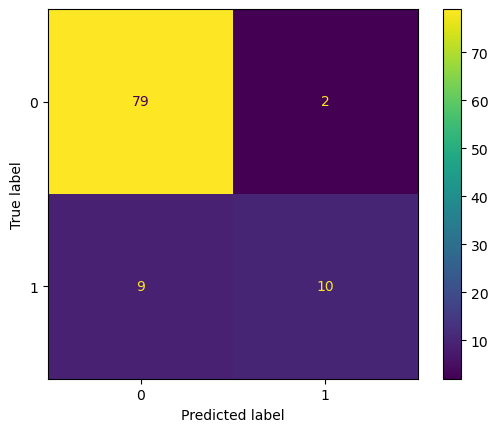

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = model.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);